## Business understanding
Notebook to answer following questions:
    1. When is the best time to rent out a flat
    2. Where is the cheapest location to rent
    3. How well is the price of a flat predictable?
    
 This analysis is using the AirBnB dataset in order to find out more about prices and locations in Seatle.

## Starting with importing all necessary libraries an the datasets

In [34]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df_cal = pd.read_csv('./calendar.csv')
df_list = pd.read_csv('./listings.csv')
df_rev = pd.read_csv('./reviews.csv') #Review csv is not needed for this analysis

## Data Understanding

In [3]:
df_cal.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
df_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


### Data Preparation

In [5]:
#merging both datasets on column listing_id
df_list = df_list.rename(index=str, columns={"id": "listing_id"})
df = pd.merge(df_cal, df_list, on = 'listing_id')

#dropping columns not relevant for the analysis
df = df.drop(columns = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month'])

#extracting year and month from the date and dropping all entries != 2016
df['year'] =  [string[:4] for string in df['date']]
df['date'] = [string[5:-3] for string in df['date']]
df['year'] = df['year'].astype(int)
df['date'] = df['date'].astype(int)
df = df[df["year"] == 2016]

#transforming price as float and dropping all NaN-values as there was no listing
df["price_x"] = df["price_x"].str.replace("$", "").str.replace(",", "").astype(float)
df = df.dropna(subset=['price_x'])

In [51]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928844 entries, 0 to 1393213
Data columns (total 39 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   listing_id                        928844 non-null  int64  
 1   date                              928844 non-null  int32  
 2   price_x                           928844 non-null  float64
 3   space                             801646 non-null  object 
 4   host_since                        928752 non-null  object 
 5   host_response_time                821175 non-null  object 
 6   host_response_rate                821175 non-null  object 
 7   host_is_superhost                 928752 non-null  object 
 8   host_listings_count               928752 non-null  float64
 9   host_verifications                928844 non-null  object 
 10  host_has_profile_pic              928752 non-null  object 
 11  host_identity_verified            928752 non-null  

## Q1: When is the best time to rent out a flat
#### To adress this question we calculate the amount of listings for each month and its prices

In [7]:
#counting the amount of listings for each month of the year
listing_month = pd.Series([12])
for i in range(1, 13):
    listing_month[i] = df[(df['date'] == i)]['listing_id'].count()

listing_month = listing_month.drop(0)
listing_month.head()

1    59239
2    73321
3    83938
4    76037
5    79971
dtype: int64

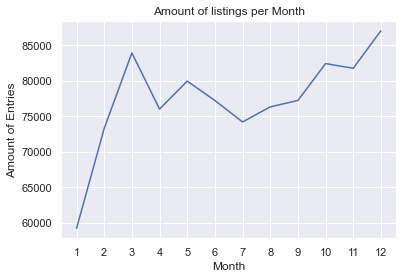

In [52]:
#plotting amount of listings on a monthly basis. 
#This might be an indicator when a good time to travel is as there are more offerings in specific months
listing_month.plot(x="month", y='available')
plt.xlabel("Month")
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel("Amount of Entries")
plt.title("Amount of listings per Month")
legend = plt.legend('')
legend.remove()
plt.show()

In [76]:
#In january are the least listings per month and a clear peak can be seen in december.

In [73]:
#Calculating the price for all listings per month for calculating the avg.-price later on.

def monthspend(df):
    '''
    calculates the monthly spendings in total
    input: 
            dataframe containing all listings
    reutrns:
            monthly_spending: costs for all available places per month in total
    
    '''
    monthly_spending = pd.Series([12])
    for i in range(1, 13):
        monthly_spending[i] = df[(df['date'] == i)]['price_x'].sum()
    monthly_spending = monthly_spending.drop(0)
    return monthly_spending
monthly_spending = monthspend(df)

monthly_spending.head()

1     7201591.0
2     9113355.0
3    10798161.0
4    10272371.0
5    11159008.0
dtype: float64

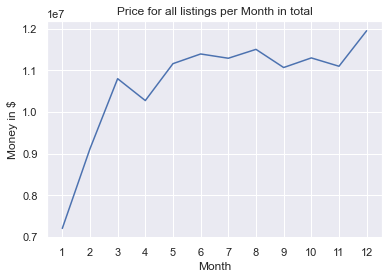

In [54]:
#plotting the price for all listings per month

#plotting 
monthly_spending.plot(x="date", y="count")
plt.xticks(np.arange(1, 13, step=1))
plt.xlabel("Month")
plt.ylabel("Money in $")
plt.title("Price for all listings per Month in total")
legend = plt.legend('')
legend.remove()

plt.show()

In [55]:
#now we can calculate the average price per night and month by dividing the monthly spendings and the amount of listings

In [12]:
avg_night = monthly_spending / listing_month
avg_night

1     121.568409
2     124.293927
3     128.644488
4     135.097005
5     139.538183
6     147.473137
7     152.094150
8     150.656594
9     143.255949
10    137.031939
11    135.688738
12    137.251835
dtype: float64

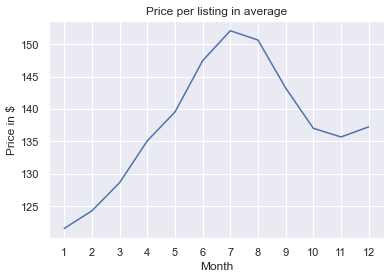

In [56]:
#plotting the avg price per month and listing

#plotting 
avg_night.plot(x="date_y", y="mul")
plt.xticks(np.arange(1, 13, step=1))
plt.xlabel("Month")
plt.ylabel("Price in $")
plt.title("Price per listing in average")
legend = plt.legend('')
legend.remove()
ax = plt.gca()
#ax.set_ylim([120, 130])


plt.show()

In [75]:
# There is a clear peak in June / July and a small rise in december again in the price. January is in averga the cheapes month

## Q2: Where is the cheapest location to rent

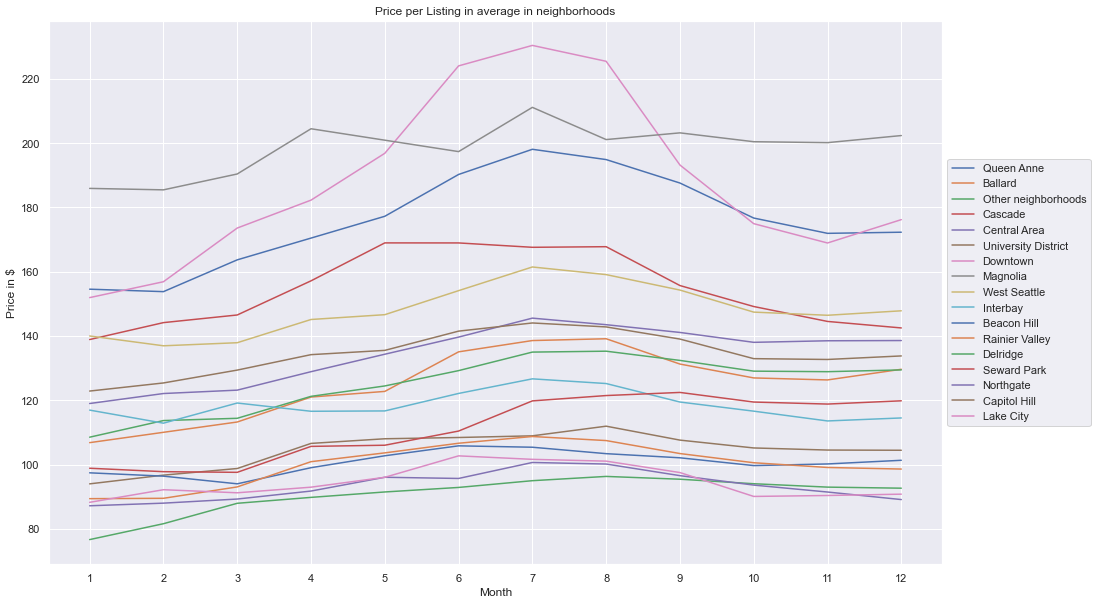

In [60]:
#Now lets see whether the avg-price differs between the neighbourhoods

#get a list of neighbourhoods
neighbourhoods = df['neighbourhood_group_cleansed'].unique()

#get prices by month and neighbourhood
price_by_month_neighbourhood = df.groupby(['date','neighbourhood_group_cleansed']).mean().reset_index()

#plot prices for each neighbourhood
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.xticks(np.arange(1, 13, step=1))
plt.xlabel("Month")
plt.ylabel("Price in $")
plt.title("Price per Listing in average in neighborhoods")


for neighbourhood in neighbourhoods:
    ax.plot(price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['date'],
             price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['price_x'],
             label = neighbourhood)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [74]:
#We can see the spread in prices is very high in the different locations as well as the prices also varie a lot in the
#different months a year

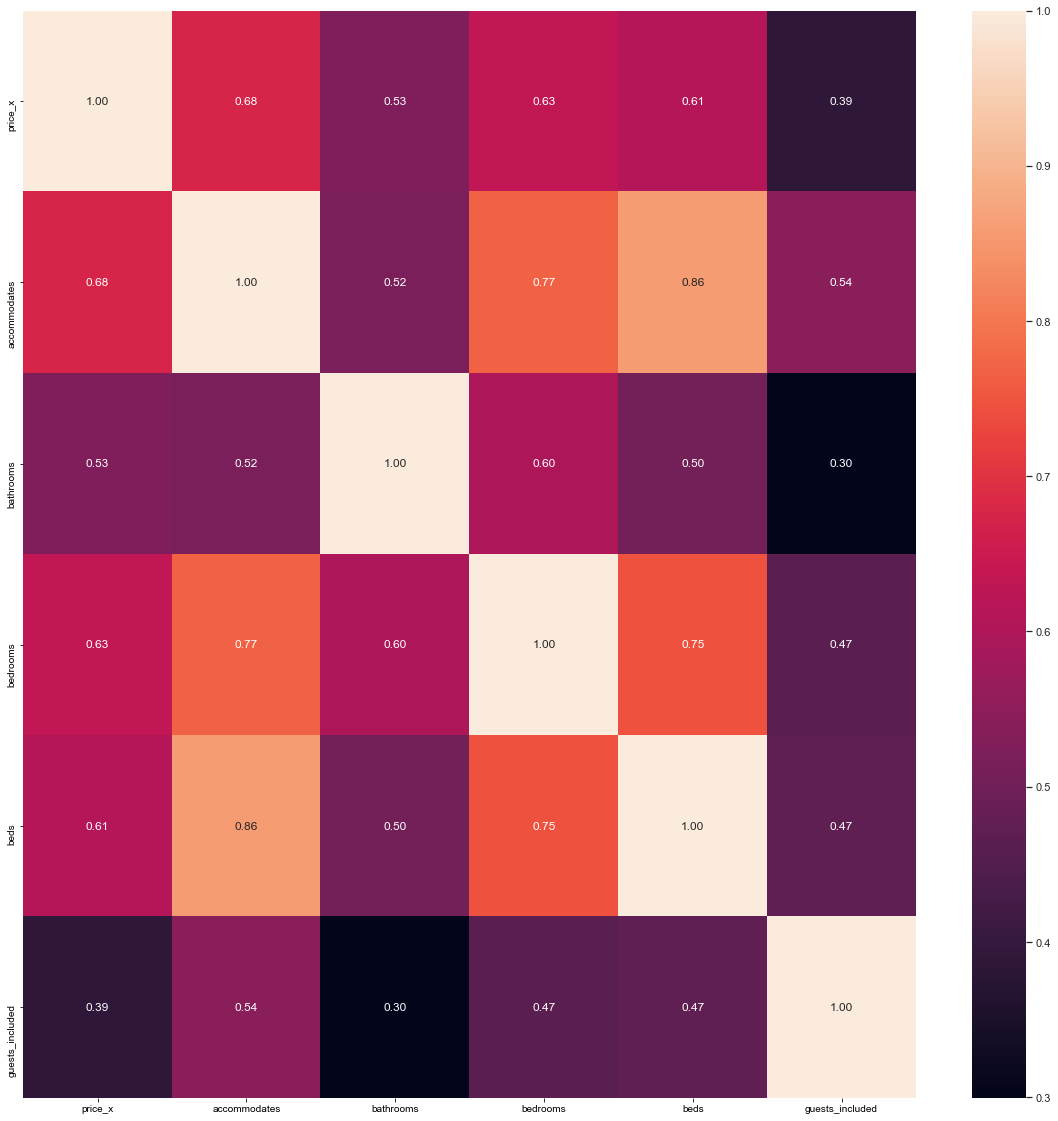

In [16]:
#checking the correlation between different attributes - the review based features were not included here
fig, ax = plt.subplots(figsize=(20,20))    
sns.set(rc={'figure.figsize':(7,7)})
sns.heatmap(df[['price_x','accommodates','bathrooms','bedrooms','beds','guests_included']].corr(), annot=True, fmt=".2f");

## Q3: Predicting the Price / Modeling
Let's predict the price based on the month, neighborhood, accommodates, bedrooms, beds

In [62]:
#preparing the dataset for a prediction
df_pred = df[['date', 'price_x', 'neighbourhood_group_cleansed', 'accommodates', 'bathrooms', 'bedrooms']]
df_pred.dropna(axis=0,subset=['bathrooms'],inplace=True)
df_pred.dropna(axis=0,subset=['bedrooms'],inplace=True)

<ipython-input-62-726c78c1518e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred.dropna(axis=0,subset=['bathrooms'],inplace=True)
<ipython-input-62-726c78c1518e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred.dropna(axis=0,subset=['bedrooms'],inplace=True)


In [63]:
#Checking if there are some NaN values
df_pred.isna().sum()

date                            0
price_x                         0
neighbourhood_group_cleansed    0
accommodates                    0
bathrooms                       0
bedrooms                        0
dtype: int64

In [36]:
#encoding the categorial variables with one-hot-encoding
df_encoded = pd.get_dummies(df_pred, columns=['neighbourhood_group_cleansed', ])
df_encoded

,date,price_x,accommodates,bathrooms,bedrooms,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,...,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle
0,1,85.0,4,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,85.0,4,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,1,85.0,4,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,1,85.0,4,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14,1,85.0,4,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393207,1,87.0,3,1.5,2.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1393208,1,87.0,3,1.5,2.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1393211,1,87.0,3,1.5,2.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1393212,1,87.0,3,1.5,2.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [67]:
#To predict the price we store all columns except the price in X and price in y
X = df_encoded.drop('price_x', axis=1)
y = df_encoded['price_x']

#Splitting the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate a linear model
lm_model = LinearRegression(normalize=True) 

#fitting the model
lm_model.fit(X_train, y_train) 

LinearRegression(normalize=True)

In [42]:
#Predicting y wih Test-data
y_pred = lm_model.predict(X_test)

In [48]:
#Calculation of the mean squared error
mean_squared_error(y_test, y_pred)

4710.870541849018

In [68]:
#Calculation of the mean error
mean_squared_error(y_test, y_pred, squared = False)

68.63578178945016

In [45]:
#Calculation of the r2 score
r2_score(y_test, y_pred)

0.5710575425323337